In [116]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import time
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

print("--Start--")
start = time.time()

# データの読み込み
test = pd.read_csv('gs://sample_machine_learning_input/HousePrices/test.csv')
df_train = pd.read_csv('gs://sample_machine_learning_input/HousePrices/train.csv')

train_id = df_train['Id']
test_id = test['Id']

#SalePriceカラム要約
print(df_train['SalePrice'].describe())
print(df_train.shape)
print(test.shape)

--Start--
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
(1460, 81)
(1459, 80)


歪度: 1.882876
尖度: 6.536282


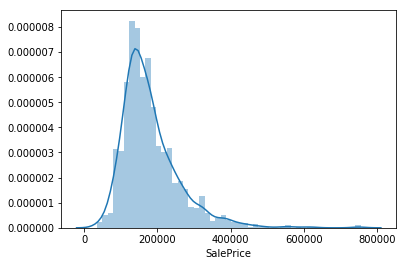

In [117]:
sns.distplot(df_train['SalePrice'])

print("歪度: %f" % df_train['SalePrice'].skew())
print("尖度: %f" % df_train['SalePrice'].kurt())

In [118]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

test = test.drop((missing_data[missing_data['Total'] > 1]).index,1)
test = test.drop(df_train.loc[df_train['Electrical'].isnull()].index)
test.isnull().sum().max()


saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)


In [119]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])


In [120]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
test['GrLivArea'] = np.log(test['GrLivArea'])

In [121]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

test['HasBsmt'] = pd.Series(len(test['TotalBsmtSF']), index=test.index)
test['HasBsmt'] = 0 
test.loc[test['TotalBsmtSF']>0,'HasBsmt'] = 1

df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
test.loc[test['HasBsmt']==1,'TotalBsmtSF'] = np.log(test['TotalBsmtSF'])

In [122]:
#df_train = pd.get_dummies(df_train)
#test = pd.get_dummies(test)

# データタイプがobjectの列の値をラベル化した数値に変換
for i in range(df_train.shape[1]):
    if df_train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(df_train.iloc[:,i].values) + list(test.iloc[:,i].values))
        df_train.iloc[:,i] = lbl.transform(list(df_train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))
        

Xmat = pd.concat([df_train, test])  
#欠損値の少ないカラムのNaNは中央値(median)で埋める
Xmat = Xmat.fillna(Xmat.median())
#trainデータとtestデータを含んでいるXmatを、再度trainデータとtestデータに分割
df_train = Xmat.iloc[:df_train.shape[0],:]
test = Xmat.iloc[df_train.shape[0]:,:]


In [123]:
y = df_train['SalePrice']
df_train = df_train.drop(['Id','SalePrice'],axis=1)
test = test.drop(['Id','SalePrice'],axis=1)


In [124]:
skl = LinearRegression()
skl.fit(df_train,y)
print(skl.score(df_train,y))

0.9197755948458384


In [125]:
# 正則化回帰モデル　Lasso Regression ########
clf = Lasso(alpha=0.00001)
clf_data = clf.fit(df_train,y)
print(clf.score(df_train,y))

0.9197701358274035


In [126]:
#result = skl.predict(test)

blend_models_predict = ((0.5 * skl.predict(test)) 
                        + (0.5 * clf.predict(test)) )


result = np.exp(blend_models_predict)

submission = pd.DataFrame({
    "Id": test_id,
    "SalePrice": result
})
submission.to_csv('gs://sample_machine_learning_output/HousePrices/hp_submission8.csv', index=False)
########
elapsed_time = time.time() - start
print ("経過時間:{0}".format(elapsed_time) + "[sec]")
print("--End--")

経過時間:1.5853550434112549[sec]
--End--
